# pyLETKF demo
pyLETKF is a full cython-based LETKF (Local Ensemble Transform Kalman Filter) python API.  
In a practical case, what you need to do is just as below:  
1. create pyLETKF instance and setup instance variables for your assimilation (domain, resolution, observation info. etc.)  
2. call pyLETKF.letkf(args*) to conduct an assimilation  

In this demo, the usage of pyLETKF.letkf() is shown with a simple model and dataset.

In [1]:
import numpy as np
import src.pyletkf as pyletkf
import scipy as sp

## create ocean mask
First let's generate land-sea mask to pass to the API. These grids will be excluded from an assimilation.  
legend:  
0:land  
1:ocean  

In [2]:
lsmask = np.array([[1,1,1,1,1],
                   [1,1,1,1,1],
                   [1,0,0,1,1]])
ocean = np.array([[0,0,0,0,0],
                  [0,0,0,0,0],
                  [0,1,1,0,0]])

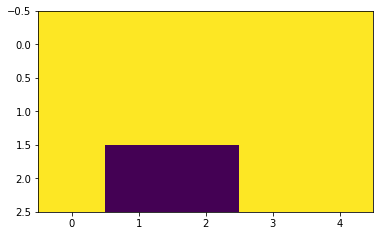

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(lsmask)

## create excluded grids
Then generate user-defined excluded grids. These grinds are not necessarily ocean, but grids users want to exclude from their assimilation (e.g., observation quality is not enough). In case you do not have such grids, just prepare a matrix filled with 1.  
legend:  
1:include  
0:exclude

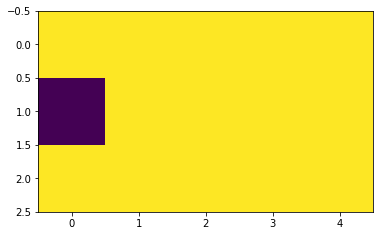

In [4]:
excGrid = np.array([[1,1,1,1,1],
                    [0,1,1,1,1],
                    [1,1,1,1,1]])
plt.imshow(excGrid)

# create observation error map
Then generate user-defined observation error map.  

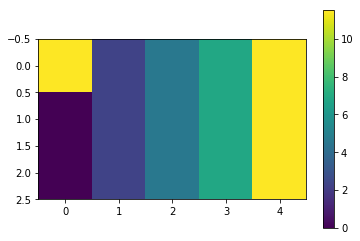

In [5]:
obs_mask = lsmask
obserr = np.array([[100000,10,100,1000,100000],
                   [1,10,100,1000,100000],
                   [1,10,100,1000,100000]])
plt.figure();plt.imshow(np.log(obserr));plt.colorbar()

## forward model
Every data assimilation needs forward model which proceed timestep to one step future. Here, just a simple cosine based model is used. This is generally your model that you want to assimilate.

In [6]:
def forward(x):
    xNext = np.abs(x*np.cos(5*x))
    return xNext

## observation
Here, just prepare the pseudo observation for this demo.

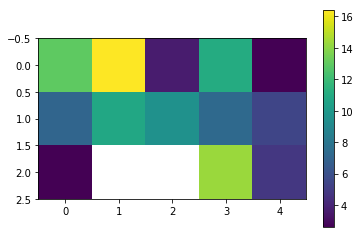

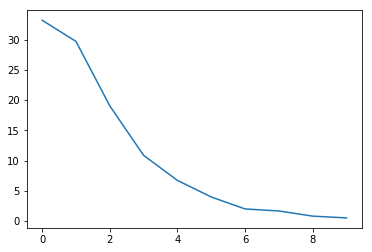

In [7]:
obs_mask = lsmask
obs = np.ones([10,3,5])*10 + np.abs(np.random.normal(10,5,[10,3,5]))
for t in range(1,10):
    obs[t] = forward(obs[t-1]) + np.random.normal(0,0.05)
obs = obs*obs_mask
obs[np.where(obs==0)] = -9999
plt.figure();plt.imshow(np.ma.masked_less(obs.mean(axis=0),-5000));plt.colorbar()
plt.figure();plt.plot(obs[:,1,1])

## ensemble simulations
Now let's create ensembles with the model!

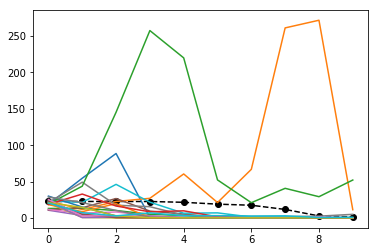

In [8]:
sim = np.ones([10,20,3,5])*10 + np.abs(np.random.normal(10,5,[10,20,3,5]))
for e in range(0,20):
    for t in range(1,10):
        sim[t,e,:,:] = forward(sim[t-1,e,:,:] + sim[t-1,e,:,:]*np.random.normal(0,1,[3,5]))
plt.figure()
plt.plot(obs[:,0,1],label="observation",color="k",linestyle="--",marker="o")
for e in range(0,20):
    plt.plot(sim[:,e,0,1])

## pyLETKF setup
pyLETKF needs to be set up for your simulation. below are the variables need to be specified.

In [9]:
am = pyletkf.LETKF_core()
am.assimN = 1
am.assimS = -1
am.assimE = 3
am.assimW = -1
am.patch = 1
am.ensMem = 20
am.nLon = 5
am.nLat = 3
am.res = 1.
am.north = 1
am.south = -1
am.east = 3
am.west = -1
am.undef = -9999

If any required variable was not specified, an IOError will be raised.

## assimilation!
It's time to assimilate! To assimilate in a given time step, only you need to do is call letkf() method in your pyLETKF instance.  
Make sure that your argument is in a correct order: ensemble siulations, observations, ocean, and excuded grids.

In [10]:
assim = np.zeros_like(sim)
for t in range(0,10):
    if t == 0:
        sim_t = sim[0]
    else:
        sim_t = np.zeros([20,3,5])
        for e in range(0,20):
            sim_t[e,:,:] = forward(assim[t-1,e,:,:])
    sim_t = sim_t.astype(np.float32)
    obs_t = obs[t].astype(np.float32)
    ax = am.letkf(sim_t.astype(np.float64),obs_t.astype(np.float64),obserr.astype(np.float64),ocean.astype(np.float64),excGrid.astype(np.float64))
    assim[t]= ax

[[1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-10 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-04 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-10]]
[[1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-04 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-10 0.e+00 0.e+00 0.e+00]
 [0.e+00 

[[1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-02 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-10 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-10 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-02]]
[[1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-02 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 

[[1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-10 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-10 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-10]]
[[1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-02 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-10 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 

Let's check results!

Text(0.5,1,'ensemble mean')

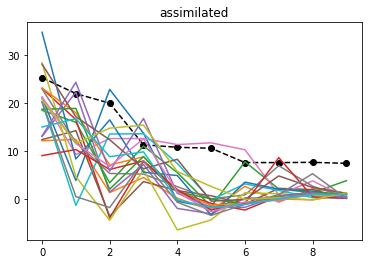

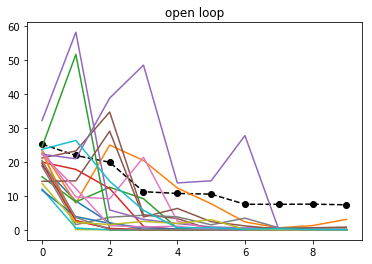

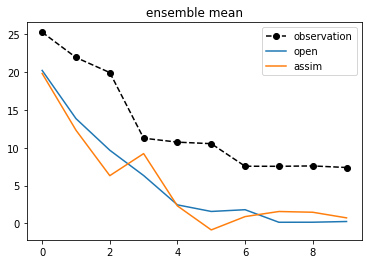

In [12]:
new = assim
x = 0
y = 0
plt.figure()
plt.plot(obs[:,y,x],label="observation",color="k",linestyle="--",marker="o")
for e in range(0,20):
    plt.plot(new[:,e,y,x])
plt.title("assimilated")
plt.figure()
plt.plot(obs[:,y,x],label="observation",color="k",linestyle="--",marker="o")
for e in range(0,20):
    plt.plot(sim[:,e,y,x])
plt.title("open loop")
plt.figure()
plt.plot(obs[:,y,x],label="observation",color="k",linestyle="--",marker="o")
plt.plot(sim[:,:,y,x].mean(axis=1),label="open")
plt.plot(new[:,:,y,x].mean(axis=1),label="assim")
plt.legend()
plt.title("ensemble mean")

Sweet. Enjoy this toy demo by changing experiment set-ups.  
Thanks for using pyLETKF!